In [1]:
from gensim.models import KeyedVectors
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse import csr_matrix, coo_matrix, triu
from incremental_coo_matrix import IncrementalCOOMatrix
import hnswlib
import numpy as np
import pickle
import matplotlib.pyplot as plt

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
threshold = 0.0

# Methods

In [3]:
def read_embedding(embedding_file_path, binary):
    model = KeyedVectors.load_word2vec_format(embedding_file_path, binary=binary)
    return model

In [4]:
def read_raw_dataset(document_path):
    arq = open(document_path, 'r', encoding="utf-8")
    doc = arq.readlines()
    arq.close()
    documents = list(map(str.rstrip, doc))
    return documents

In [5]:
def load_vocabulary(documents):
    # Count the words in dataset
    dataset_cv = CountVectorizer().fit(documents)
    vocabulary = dataset_cv.get_feature_names()
    return vocabulary

In [6]:
def filter_embedding_models(vocabulary, model, dimension):
    vocabulary_embedding = list()
    word_vectors = list()
    
    for word in vocabulary:
        if word in model:
            vocabulary_embedding.append(word)
            word_vectors.append(np.asarray(model[word], dtype=np.float64))

    n_words = len(vocabulary_embedding)  # Number of words selected

    return np.asarray(word_vectors), np.sort(np.asarray(vocabulary_embedding)), n_words

In [7]:
def build_word_vector_matrix(words_values, n_words):
    numpy_arrays = list()
    labels_array = list()

    for r in words_values:
        sr = r.split()
        labels_array.append(sr[0])
        numpy_arrays.append(np.array([float(i) for i in sr[1:]]))

    return np.array(numpy_arrays), np.asarray(labels_array)

In [8]:
def create_cosine_matrix(word_vectors, 
                         vocabulary_embedding):
    cosine_matrix = triu(cosine_similarity(word_vectors, word_vectors))
    return cosine_matrix

# Dataset face

In [9]:
document_path = "/home/felipeviegas/Codes_phd/cluwords_arc/fasttext_wiki/datasets/debate_2L/d_train_data_0.txt"

## FastText embedding

In [47]:
embedding_file_path = "/home/felipeviegas/Codes_phd/cluwords_arc/wiki-news-300d-1M.vec"
model = read_embedding(embedding_file_path=embedding_file_path, 
                       binary=False)
documents = read_raw_dataset(document_path)
vocabulary = load_vocabulary(documents)
word_vectors, vocabulary_embedding, n_words = filter_embedding_models(vocabulary=vocabulary, model=model, dimension=300)

## hnswlib

In [48]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = 300) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = n_words, ef_construction = 200, M = 32)

word_vectors_labels = np.arange(n_words)
# Element insertion (can be called several times):
p.add_items(word_vectors, word_vectors_labels)

# Controlling the recall by setting ef:
p.set_ef(600) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels_fasttext, distances_fasttext = p.knn_query(word_vectors, k = 500)

cosine_matrix = 1. - distances_fasttext

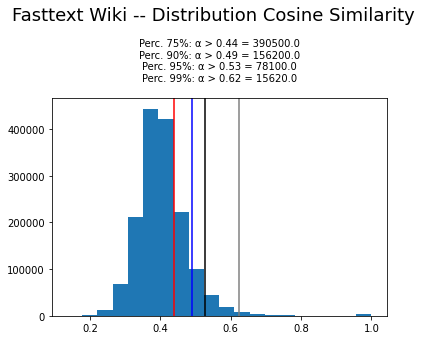

In [49]:
cosine_vec = cosine_matrix.flatten()
plt.figure()
_ = plt.hist(cosine_vec, bins=20)
title_string = "Fasttext Wiki -- Distribution Cosine Similarity"
subtitle_string = f"Perc. 75%: α > {np.round_(np.percentile(cosine_vec, 75), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 75)) * 1.)}\n" \
                  f"Perc. 90%: α > {np.round_(np.percentile(cosine_vec, 90), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 90)) * 1.)}\n" \
                  f"Perc. 95%: α > {np.round_(np.percentile(cosine_vec, 95), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 95)) * 1.)}\n" \
                  f"Perc. 99%: α > {np.round_(np.percentile(cosine_vec, 99), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99)) * 1.)}\n"

plt.suptitle(title_string, y=1.2, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.axvline(np.percentile(cosine_vec, 75), color='red')
plt.axvline(np.percentile(cosine_vec, 90), color='blue')
plt.axvline(np.percentile(cosine_vec, 95), color='black')
plt.axvline(np.percentile(cosine_vec, 99), color='gray')

plt.show()

# BERT Embedding

In [20]:
embedding_file_path = "/home/felipeviegas/Codes_phd/cluwords_arc/bert_embeddings_colab/word-embedding_aisopos_ntua_2L-4.txt"
model = read_embedding(embedding_file_path=embedding_file_path, 
                       binary=False)
documents = read_raw_dataset(document_path)
vocabulary = load_vocabulary(documents)
word_vectors, vocabulary_embedding, n_words = filter_embedding_models(vocabulary=vocabulary, model=model, dimension=300)

## hnswlib

In [21]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = 3072) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = n_words, ef_construction = 200, M = 32)

word_vectors_labels = np.arange(n_words)
# Element insertion (can be called several times):
p.add_items(word_vectors, word_vectors_labels)

# Controlling the recall by setting ef:
p.set_ef(600) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels_fasttext, distances_fasttext = p.knn_query(word_vectors, k = 500)

cosine_matrix = 1. - distances_fasttext

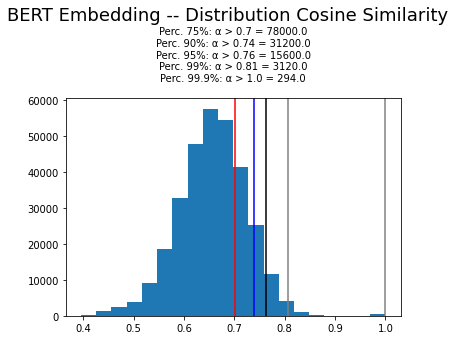

In [22]:
cosine_vec = cosine_matrix.flatten()
plt.figure()
_ = plt.hist(cosine_vec, bins=20)
title_string = "BERT Embedding -- Distribution Cosine Similarity"
subtitle_string = f"Perc. 75%: α > {np.round_(np.percentile(cosine_vec, 75), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 75)) * 1.)}\n" \
                  f"Perc. 90%: α > {np.round_(np.percentile(cosine_vec, 90), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 90)) * 1.)}\n" \
                  f"Perc. 95%: α > {np.round_(np.percentile(cosine_vec, 95), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 95)) * 1.)}\n" \
                  f"Perc. 99%: α > {np.round_(np.percentile(cosine_vec, 99), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99)) * 1.)}\n" \
                  f"Perc. 99.9%: α > {np.round_(np.percentile(cosine_vec, 99.9), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99.9)) * 1.)}\n"

plt.suptitle(title_string, y=1.2, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.axvline(np.percentile(cosine_vec, 75), color='red')
plt.axvline(np.percentile(cosine_vec, 90), color='blue')
plt.axvline(np.percentile(cosine_vec, 95), color='black')
plt.axvline(np.percentile(cosine_vec, 99), color='gray')
plt.axvline(np.percentile(cosine_vec, 99.9), color='gray')

plt.show()

In [23]:
embedding_file_path = "/home/felipeviegas/Codes_phd/cluwords_arc/bert_embeddings_colab_without_shuffle_batch_16/word-embedding_aisopos_ntua_2L-4.txt"
model = read_embedding(embedding_file_path=embedding_file_path, 
                       binary=False)
documents = read_raw_dataset(document_path)
vocabulary = load_vocabulary(documents)
word_vectors, vocabulary_embedding, n_words = filter_embedding_models(vocabulary=vocabulary, model=model, dimension=300)

In [24]:
# Declaring index
p = hnswlib.Index(space = 'cosine', dim = 3072) # possible options are l2, cosine or ip

# Initializing index - the maximum number of elements should be known beforehand
p.init_index(max_elements = n_words, ef_construction = 200, M = 32)

word_vectors_labels = np.arange(n_words)
# Element insertion (can be called several times):
p.add_items(word_vectors, word_vectors_labels)

# Controlling the recall by setting ef:
p.set_ef(600) # ef should always be > k

# Query dataset, k - number of closest elements (returns 2 numpy arrays)
labels_fasttext, distances_fasttext = p.knn_query(word_vectors, k = 500)

cosine_matrix = 1. - distances_fasttext

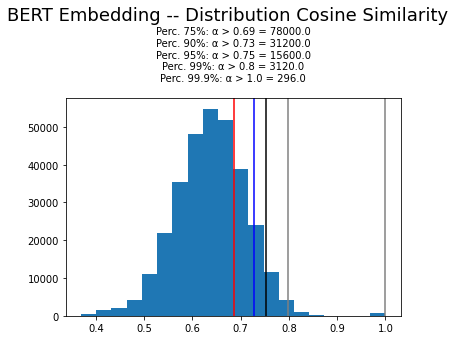

In [25]:
cosine_vec = cosine_matrix.flatten()
plt.figure()
_ = plt.hist(cosine_vec, bins=20)
title_string = "BERT Embedding -- Distribution Cosine Similarity"
subtitle_string = f"Perc. 75%: α > {np.round_(np.percentile(cosine_vec, 75), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 75)) * 1.)}\n" \
                  f"Perc. 90%: α > {np.round_(np.percentile(cosine_vec, 90), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 90)) * 1.)}\n" \
                  f"Perc. 95%: α > {np.round_(np.percentile(cosine_vec, 95), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 95)) * 1.)}\n" \
                  f"Perc. 99%: α > {np.round_(np.percentile(cosine_vec, 99), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99)) * 1.)}\n" \
                  f"Perc. 99.9%: α > {np.round_(np.percentile(cosine_vec, 99.9), 2)} = {np.sum((cosine_vec > np.percentile(cosine_vec, 99.9)) * 1.)}\n"

plt.suptitle(title_string, y=1.2, fontsize=18)
plt.title(subtitle_string, fontsize=10)

plt.axvline(np.percentile(cosine_vec, 75), color='red')
plt.axvline(np.percentile(cosine_vec, 90), color='blue')
plt.axvline(np.percentile(cosine_vec, 95), color='black')
plt.axvline(np.percentile(cosine_vec, 99), color='gray')
plt.axvline(np.percentile(cosine_vec, 99.9), color='gray')

plt.show()